## Notebook de l'exploration et pre-traitement des questions du corpus

### A. Pre-requis

In [364]:
# Importation des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/valou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/valou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/valou/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/valou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/valou/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [365]:
# Requete SQL pour recuperer les individus depuis StackExchange Data Explorer.

'''
SELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount
FROM Posts 
WHERE PostTypeId = 1
AND ViewCount IS NOT NULL
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5
'''

"\nSELECT TOP 50000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount\nFROM Posts \nWHERE PostTypeId = 1\nAND ViewCount IS NOT NULL\nAND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\n"

In [366]:
# Chargement du dataset

dataset = pd.read_csv('dataset/stack_overflow_query_result.csv')

In [367]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          50000 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  0 non-null      float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [368]:
dataset.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.000000,5.000000e+04,0.0,50000.00000
mean,1.562872e+06,25.357040,2.371003e+04,NaN,3.58756
std,7.694544e+05,217.521498,1.506203e+05,NaN,3.99613
min,4.000000e+00,-6.000000,2.900000e+01,NaN,0.00000
25%,9.314418e+05,1.000000,1.038000e+03,NaN,1.00000
50%,1.614784e+06,2.000000,2.637000e+03,NaN,3.00000
75%,2.239268e+06,7.000000,8.269000e+03,NaN,4.00000
max,2.776234e+06,20372.000000,1.192372e+07,NaN,131.00000


In [369]:
dataset.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...",<linux><winapi><visual-c++><unix><timer>,88,107,45385,NaN,10
1,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,<c#><sql><vb.net><ascii><hex>,109,68,6252,NaN,2
2,Displaying Flash content in a C# WinForms appl...,<p>What is the best way to display <code>Flash...,<c#><winforms><flash><adobe><macromedia>,1037,40,37517,NaN,2
3,Why doesn't SQL Full Text Indexing return resu...,"<p>For instance, my query is like the followin...",<sql><sql-server><sql-server-2005><indexing><f...,1042,26,9479,NaN,2
4,How can I unit test Flex applications from wit...,<p>I'm currently working on an application wit...,<apache-flex><eclipse><unit-testing><build-aut...,2222,18,2764,NaN,4


### B. Nettoyage du dataset

#### Formatage de la variable 'Tags'

In [370]:
# Nettoyer le formatage de la variables 'Tags' en enlevant '<' puis en supprimant le dernier caractere '>' et en decoupant la chaine par '>'

def process_tags(tags):
    """
    Transforme une chaîne de caractères contenant des tags délimités par '<' et '>'.
    
    Cette fonction remplace les caractères '<' dans la chaîne par des chaînes vides, 
    enlève le dernier caractère de la chaîne résultante, puis divise la chaîne restante 
    en une liste de sous-chaînes en utilisant '>' comme délimiteur.

    Args:
        tags (str): Une chaîne de caractères contenant des tags délimités par '<' et '>'.

    Returns:
        list: Une liste de chaînes, où chaque chaîne est un tag extrait de l'entrée.
    """
    return tags.replace('<', '')[0:-1].split('>')

dataset['Tags'] = dataset['Tags'].apply(process_tags)

In [371]:
dataset['Tags'].head()

0             [linux, winapi, visual-c++, unix, timer]
1                        [c#, sql, vb.net, ascii, hex]
2             [c#, winforms, flash, adobe, macromedia]
3    [sql, sql-server, sql-server-2005, indexing, f...
4    [apache-flex, eclipse, unit-testing, build-aut...
Name: Tags, dtype: object

#### Suppression de la variable 'FavoriteCount'

In [372]:
# Suppression de la variable 'FavoriteCount' du dataset.
# Cette variable est vide du fait d'un bug avec Stack Exchange Data Explorer

dataset.drop(columns='FavoriteCount', inplace=True)

#### Tokenisation de la variable 'Title'

In [373]:
# Fonction de tokenisation de la variable 'Title'

def gen_token(word):
    """
    Cette fonction prend en entrée une chaîne de caractères (word) et retourne
    une liste de tokens générés à partir de cette chaîne en utilisant un 
    tokenizer basé sur des expressions régulières. Elle conserve également
    certains caractères spéciaux comme le '#' et l'apostrophe.

    Args:
    word (str): La chaîne de caractères à tokenizer.

    Returns:
    list: Une liste contenant les tokens générés à partir de la chaîne de caractères.
    """
    tokenizer = nltk.RegexpTokenizer(r"[\w#'().]+")
    return tokenizer.tokenize(word)

# On applique la fonction a la variable 'Title'
dataset['title_tokenize'] = dataset['Title'].apply(gen_token)

In [374]:
dataset.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,title_tokenize
0,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...","[linux, winapi, visual-c++, unix, timer]",88,107,45385,10,"[Is, gettimeofday(), guaranteed, to, be, of, m..."
1,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,"[c#, sql, vb.net, ascii, hex]",109,68,6252,2,"[Decoding, T, SQL, CAST, in, C#, VB.NET]"
2,Displaying Flash content in a C# WinForms appl...,<p>What is the best way to display <code>Flash...,"[c#, winforms, flash, adobe, macromedia]",1037,40,37517,2,"[Displaying, Flash, content, in, a, C#, WinFor..."
3,Why doesn't SQL Full Text Indexing return resu...,"<p>For instance, my query is like the followin...","[sql, sql-server, sql-server-2005, indexing, f...",1042,26,9479,2,"[Why, doesn't, SQL, Full, Text, Indexing, retu..."
4,How can I unit test Flex applications from wit...,<p>I'm currently working on an application wit...,"[apache-flex, eclipse, unit-testing, build-aut...",2222,18,2764,4,"[How, can, I, unit, test, Flex, applications, ..."


#### Tokenisation de la variable 'Body'

In [375]:
# Fonction de tokenisation de la variable 'Body'

dataset['body_tokenize'] = dataset['Body'].apply(gen_token)

In [376]:
dataset.head()

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,title_tokenize,body_tokenize
0,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...","[linux, winapi, visual-c++, unix, timer]",88,107,45385,10,"[Is, gettimeofday(), guaranteed, to, be, of, m...","[p, I, am, porting, a, game, that, was, origin..."
1,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,"[c#, sql, vb.net, ascii, hex]",109,68,6252,2,"[Decoding, T, SQL, CAST, in, C#, VB.NET]","[p, Recently, our, site, has, been, deluged, w..."
2,Displaying Flash content in a C# WinForms appl...,<p>What is the best way to display <code>Flash...,"[c#, winforms, flash, adobe, macromedia]",1037,40,37517,2,"[Displaying, Flash, content, in, a, C#, WinFor...","[p, What, is, the, best, way, to, display, cod..."
3,Why doesn't SQL Full Text Indexing return resu...,"<p>For instance, my query is like the followin...","[sql, sql-server, sql-server-2005, indexing, f...",1042,26,9479,2,"[Why, doesn't, SQL, Full, Text, Indexing, retu...","[p, For, instance, my, query, is, like, the, f..."
4,How can I unit test Flex applications from wit...,<p>I'm currently working on an application wit...,"[apache-flex, eclipse, unit-testing, build-aut...",2222,18,2764,4,"[How, can, I, unit, test, Flex, applications, ...","[p, I'm, currently, working, on, an, applicati..."


In [377]:
from collections import defaultdict

corpora = defaultdict(list)

# Création d'un corpus de tokens par artiste
for idx, row in dataset.iterrows():
       id = row['Id']
       text = row['body_tokenize']  # Colonne contenant le texte des chansons
       corpora[id] += gen_token(str(text).lower())

In [378]:
stats, freq = dict(), dict()

# Calcul des fréquences et des statistiques par artiste
for id, tokens in corpora.items():
    freq[id] = nltk.FreqDist(tokens)
    stats[id] = {'total': len(tokens)}

<Axes: title={'center': 'Top 50 des questions par nombre de mots'}>

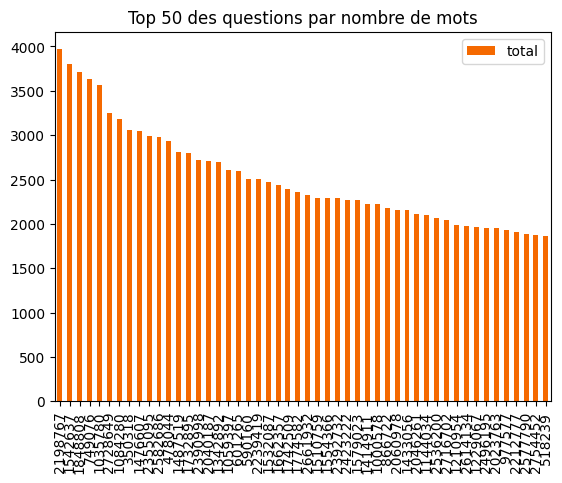

In [379]:
# Création d'un DataFrame à partir des stats
df = pd.DataFrame.from_dict(stats, orient='index')

# Tri par nombre total de mots
df_sorted = df.sort_values('total', ascending=False)

# Garder les 100 premieres lignes
df_top100 = df_sorted.head(50)

# Affichage des fréquences sous forme de graphique
df_top100.plot(kind='bar', color="#f56900", title='Top 50 des questions par nombre de mots')

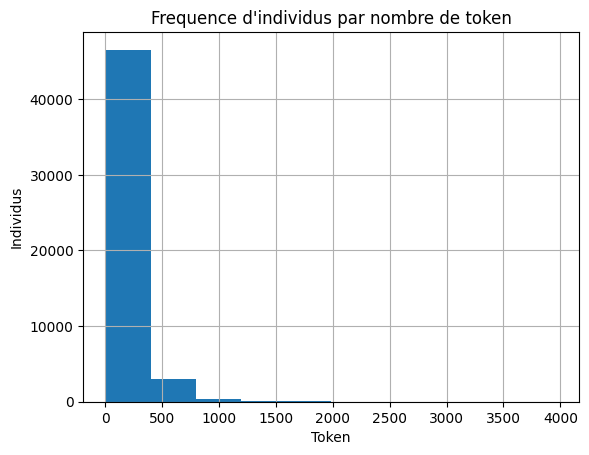

In [380]:
# Histogramme de la frequence des individus par nombre de token

# Générer l'histogramme
dataset['body_tokenize'].apply(len).sort_values(ascending=False).hist()

# Ajouter un titre
plt.title("Frequence d'individus par nombre de token")
plt.xlabel("Token")
plt.ylabel("Individus")

# Afficher le graphique
plt.show()

### C. Pre-processing

In [381]:
# Importe le corpus des stopwords pour l'anglais depuis NLTK
stopwords = nltk.corpus.stopwords.words('english')

# Crée un ensemble de mots à partir du corpus de mots anglais disponible dans NLTK
words = set(nltk.corpus.words.words())

# Initialise un objet lemmatizer de la classe WordNetLemmatizer pour le traitement de lemmatisation
lemmatizer = WordNetLemmatizer()

In [382]:
def preproc_text(text):
    """
    Cette fonction prend en entrée un tweet (chaîne de caractères) et retourne
    une version prétraitée du tweet après avoir effectué la tokenisation, la
    suppression des stopwords, la lemmatisation et le filtrage des tokens ayant moins de 3 caractères.

    Args:
    text (str): Le tweet à prétraiter.

    Returns:
    str: Le tweet prétraité sous forme de chaîne de caractères, avec les tokens
         filtrés, séparés par des espaces.
    """
    
    soup = BeautifulSoup(text, "lxml").get_text()

    # Tokenisation - modifiée pour inclure des caractères comme "#" et "."
    tokenizer = nltk.RegexpTokenizer(r"[#\w'.]+").tokenize(soup)

    # Supprimer les stopwords
    words_w_stopwords = [i for i in tokenizer if i not in stopwords]

    # Lemmatisation
    words_lemmatize = (lemmatizer.lemmatize(w) for w in words_w_stopwords)

    # Supprimer les tokens de moins de 3 caractères mais conserver ceux avec des caractères spéciaux
    words_w_stopwords_and_3char = [w.lower() for w in words_lemmatize if len(w) >= 2]

    return ' '.join(words_w_stopwords_and_3char)


In [383]:
# Pre-processing de la variable 'Body'

dataset['preproc_body'] = dataset['Body'].apply(preproc_text)

In [384]:
# Pre-processing de la variable 'Title'

dataset['preproc_title'] = dataset['Title'].apply(preproc_text)

/var/folders/b8/t710d8ys4x55cg_q12zdpnf00000gn/T/ipykernel_1592/3165081604.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "lxml").get_text()


In [385]:
dataset

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,title_tokenize,body_tokenize,preproc_body,preproc_title
0,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...","[linux, winapi, visual-c++, unix, timer]",88,107,45385,10,"[Is, gettimeofday(), guaranteed, to, be, of, m...","[p, I, am, porting, a, game, that, was, origin...",porting game originally written win32 api linu...,is gettimeofday guaranteed microsecond resolution
1,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,"[c#, sql, vb.net, ascii, hex]",109,68,6252,2,"[Decoding, T, SQL, CAST, in, C#, VB.NET]","[p, Recently, our, site, has, been, deluged, w...",recently site deluged resurgence asprox botnet...,decoding sql cast c# vb.net
2,Displaying Flash content in a C# WinForms appl...,<p>What is the best way to display <code>Flash...,"[c#, winforms, flash, adobe, macromedia]",1037,40,37517,2,"[Displaying, Flash, content, in, a, C#, WinFor...","[p, What, is, the, best, way, to, display, cod...",what best way display flash content c# winform...,displaying flash content c# winforms application
3,Why doesn't SQL Full Text Indexing return resu...,"<p>For instance, my query is like the followin...","[sql, sql-server, sql-server-2005, indexing, f...",1042,26,9479,2,"[Why, doesn't, SQL, Full, Text, Indexing, retu...","[p, For, instance, my, query, is, like, the, f...",for instance query like following using sql se...,why sql full text indexing return result word ...
4,How can I unit test Flex applications from wit...,<p>I'm currently working on an application wit...,"[apache-flex, eclipse, unit-testing, build-aut...",2222,18,2764,4,"[How, can, I, unit, test, Flex, applications, ...","[p, I'm, currently, working, on, an, applicati...",i'm currently working application frontend wri...,how unit test flex application within ide buil...
...,...,...,...,...,...,...,...,...,...,...,...
49995,Is it possible to prevent iPhone/iPad orientat...,"<p>I've seen similar questions on this issue, ...","[iphone, ipad, webkit, rotation, orientation]",2772691,7,10586,6,"[Is, it, possible, to, prevent, iPhone, iPad, ...","[p, I've, seen, similar, questions, on, this, ...",i've seen similar question issue related nativ...,is possible prevent iphone ipad orientation ch...
49996,Logging fatal/parse errors in PHP5,<p>I'm writing an error logging service that w...,"[php, fatal-error, error-logging, parse-error,...",2772699,5,1962,2,"[Logging, fatal, parse, errors, in, PHP5]","[p, I'm, writing, an, error, logging, service,...",i'm writing error logging service integrated w...,logging fatal parse error php5
49997,Address already in use: JVM_Bind java,<p>Some times whenever I restart the applicati...,"[java, web-applications, jboss, ip-address, st...",2772701,62,325225,18,"[Address, already, in, use, JVM_Bind, java]","[p, Some, times, whenever, I, restart, the, ap...",some time whenever restart application built j...,address already use jvm_bind java
49998,Selenium Testing,<p>I want to get a bunch of dom-objects with x...,"[perl, selenium, selenium-rc, selenium-ide, gu...",2773403,1,922,2,"[Selenium, Testing]","[p, I, want, to, get, a, bunch, of, dom, objec...",want get bunch dom object xpath loop check con...,selenium testing


In [386]:
# Constituer un corpus de tous les documents 'preproc_body' & 'preproc_title'

corpus_body = ' '.join(dataset['preproc_body'])
corpus_title = ' '.join(dataset['preproc_title'])

In [387]:
# Obtenir le nombre de mots unique dans le 'corpus_body'

total_mots_unique = len(set(corpus_body.split()))
print(f"""Variable : 'corpus_body'
Nombre total de mots unique : {total_mots_unique}
Nombre total de mots dans le corpus : {len(corpus_body.split())}
Ratio du nombre de mots unique : {round(total_mots_unique / len(corpus_body.split()), 4) * 100}%""")

Variable : 'corpus_body'
Nombre total de mots unique : 303197
Nombre total de mots dans le corpus : 4868109
Ratio du nombre de mots unique : 6.23%


In [388]:
# Obtenir le nombre de mots unique dans le 'corpus_title'

total_mots_unique = len(set(corpus_title.split()))
print(f"""Variable : 'corpus_title'
Nombre total de mots unique : {total_mots_unique}
Nombre total de mots dans le corpus : {len(corpus_title.split())}
Ratio du nombre de mots unique : {round(total_mots_unique / len(corpus_title.split()), 4) * 100}%""")

Variable : 'corpus_title'
Nombre total de mots unique : 22604
Nombre total de mots dans le corpus : 314346
Ratio du nombre de mots unique : 7.19%


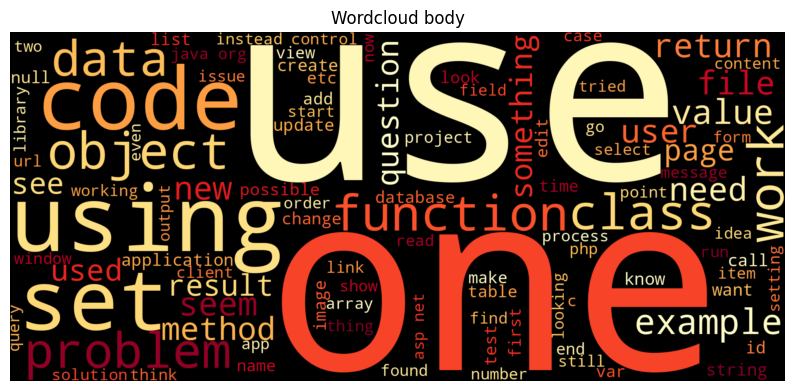

In [389]:
# Generer le WordCloud de 'corpus_body'

wordcloud = WordCloud(width=2000, 
    height=900, 
    max_words=100, 
    background_color='black', 
    colormap='YlOrRd').generate(corpus_body)

# Afficher le WordCloud de 'corpus_body'
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Wordcloud body')
plt.axis("off")
plt.show()

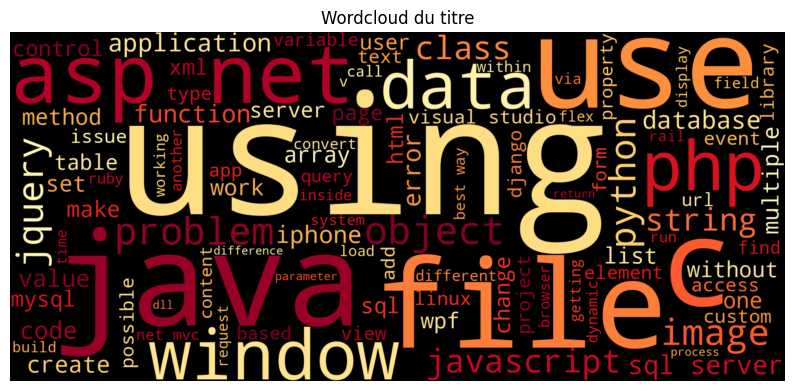

In [390]:
# Generer le WordCloud de 'corpus_title'

wordcloud = WordCloud(width=2000, 
    height=900, 
    max_words=100, 
    background_color='black', 
    colormap='YlOrRd').generate(corpus_title)

# Afficher le WordCloud de 'corpus_body'
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Wordcloud du titre")
plt.axis("off")
plt.show()

In [391]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le vectoriseur de sac de mots
vectorizer = CountVectorizer()

# Transformer le corpus en sac de mots
X = vectorizer.fit_transform(dataset['preproc_body'])

# Afficher le vocabulaire
print("Vocabulaire :")
print(vectorizer.get_feature_names_out())

# Afficher la matrice du sac de mots
print("Matrice du sac de mots :")
print(X.toarray())


Vocabulaire :
['00' '000' '0000' ... 'ｻｿ' 'ﾎｱﾎｻﾎｷﾎｼﾎｭﾏ' 'ﾎｺﾏ狐πｼﾎｵ']
Matrice du sac de mots :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [392]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialiser le vectoriseur de sac de mots
vectorizer = CountVectorizer()

# Transformer le corpus en sac de mots
X = vectorizer.fit_transform(dataset['preproc_title'])

# Afficher le vocabulaire
print("Vocabulaire :")
print(vectorizer.get_feature_names_out())

# Afficher la matrice du sac de mots
print("Matrice du sac de mots :")
print(X.toarray())


Vocabulaire :
['00' '000' '0000' ... 'òàùèéì' 'アカウントを作成します' '同意して']
Matrice du sac de mots :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [393]:
dataset

,Title,Body,Tags,Id,Score,ViewCount,AnswerCount,title_tokenize,body_tokenize,preproc_body,preproc_title
0,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...","[linux, winapi, visual-c++, unix, timer]",88,107,45385,10,"[Is, gettimeofday(), guaranteed, to, be, of, m...","[p, I, am, porting, a, game, that, was, origin...",porting game originally written win32 api linu...,is gettimeofday guaranteed microsecond resolution
1,Decoding T-SQL CAST in C#/VB.NET,<p>Recently our site has been deluged with the...,"[c#, sql, vb.net, ascii, hex]",109,68,6252,2,"[Decoding, T, SQL, CAST, in, C#, VB.NET]","[p, Recently, our, site, has, been, deluged, w...",recently site deluged resurgence asprox botnet...,decoding sql cast c# vb.net
2,Displaying Flash content in a C# WinForms appl...,<p>What is the best way to display <code>Flash...,"[c#, winforms, flash, adobe, macromedia]",1037,40,37517,2,"[Displaying, Flash, content, in, a, C#, WinFor...","[p, What, is, the, best, way, to, display, cod...",what best way display flash content c# winform...,displaying flash content c# winforms application
3,Why doesn't SQL Full Text Indexing return resu...,"<p>For instance, my query is like the followin...","[sql, sql-server, sql-server-2005, indexing, f...",1042,26,9479,2,"[Why, doesn't, SQL, Full, Text, Indexing, retu...","[p, For, instance, my, query, is, like, the, f...",for instance query like following using sql se...,why sql full text indexing return result word ...
4,How can I unit test Flex applications from wit...,<p>I'm currently working on an application wit...,"[apache-flex, eclipse, unit-testing, build-aut...",2222,18,2764,4,"[How, can, I, unit, test, Flex, applications, ...","[p, I'm, currently, working, on, an, applicati...",i'm currently working application frontend wri...,how unit test flex application within ide buil...
...,...,...,...,...,...,...,...,...,...,...,...
49995,Is it possible to prevent iPhone/iPad orientat...,"<p>I've seen similar questions on this issue, ...","[iphone, ipad, webkit, rotation, orientation]",2772691,7,10586,6,"[Is, it, possible, to, prevent, iPhone, iPad, ...","[p, I've, seen, similar, questions, on, this, ...",i've seen similar question issue related nativ...,is possible prevent iphone ipad orientation ch...
49996,Logging fatal/parse errors in PHP5,<p>I'm writing an error logging service that w...,"[php, fatal-error, error-logging, parse-error,...",2772699,5,1962,2,"[Logging, fatal, parse, errors, in, PHP5]","[p, I'm, writing, an, error, logging, service,...",i'm writing error logging service integrated w...,logging fatal parse error php5
49997,Address already in use: JVM_Bind java,<p>Some times whenever I restart the applicati...,"[java, web-applications, jboss, ip-address, st...",2772701,62,325225,18,"[Address, already, in, use, JVM_Bind, java]","[p, Some, times, whenever, I, restart, the, ap...",some time whenever restart application built j...,address already use jvm_bind java
49998,Selenium Testing,<p>I want to get a bunch of dom-objects with x...,"[perl, selenium, selenium-rc, selenium-ide, gu...",2773403,1,922,2,"[Selenium, Testing]","[p, I, want, to, get, a, bunch, of, dom, objec...",want get bunch dom object xpath loop check con...,selenium testing


In [394]:
dataset.to_csv('dataset/dataset-clean.csv')